In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
# tf.random.set_seed(123)
# np.random.seed(123)
from sklearn import metrics
import json 
import os

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}',end='\n\n')
    return {'mse' : mse, 'mae' : mae, 'rmse' : rmse, 'mape' : mape, 'r2' : r2}
    
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

# df = pd.read_csv(r'..\Data\Panama Electricity\continuous_dataset_preprocessing.csv', parse_dates= True)
df = pd.read_csv(
    "/Users/trungnguyen/Desktop/cttn-khmt-k64/deep learning/project/DL_HUST_Project/Data/Panama Electricity/continuous_dataset_preprocessing.csv",
    parse_dates=True,
)
df["datetime"] = df["datetime"].apply(pd.to_datetime)

column_names = df.columns.tolist()
train_column_names = df.columns.tolist()
column_names.remove('datetime')
train_column_names.remove('datetime')
train_column_names.remove('nat_demand')

In [2]:
valid = df[df['datetime'] <= '1/1/2019 23:00']
valid = valid[valid['datetime'] > '1/1/2018 23:00']
train = df[df['datetime'] <= '1/1/2018 23:00']
test = df[df['datetime'] > '1/1/2019 23:00']

# train['nat_demand'] = train['nat_demand'].clip(lower = 500)
# valid['nat_demand'] = valid['nat_demand'].clip(lower = 500)

# valid = df[df['datetime'] <= '12/3/2019 23:00']
# valid = valid[valid['datetime'] > '11/3/2019 23:00']
# train = df[df['datetime'] <= '11/3/2019 23:00']
# train = train[train['datetime'] > '11/3/2017 23:00']
# test = df[df['datetime'] > '12/3/2019 23:00']

x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
trainX = x_scaler.fit_transform(train[column_names])
trainY = y_scaler.fit_transform(train[['nat_demand']])
validX = x_scaler.fit_transform(valid[column_names])
validY = y_scaler.fit_transform(valid[['nat_demand']])

In [7]:
version = 1
hist_window = 30 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

The new directory is created!
Epoch 1/150
100/100 [==============================] - 7s 58ms/step - loss: 0.0653 - val_loss: 0.0594
Epoch 2/150
100/100 [==============================] - 6s 63ms/step - loss: 0.0269 - val_loss: 0.0378
Epoch 3/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0195 - val_loss: 0.0334
Epoch 4/150
100/100 [==============================] - 6s 61ms/step - loss: 0.0179 - val_loss: 0.0318
Epoch 5/150
100/100 [==============================] - 6s 63ms/step - loss: 0.0150 - val_loss: 0.0503
Epoch 6/150
100/100 [==============================] - 6s 61ms/step - loss: 0.0139 - val_loss: 0.0402
Epoch 7/150
100/100 [==============================] - 6s 61ms/step - loss: 0.0124 - val_loss: 0.0283
Epoch 8/150
100/100 [==============================] - 6s 59ms/step - loss: 0.0121 - val_loss: 0.0409
Epoch 9/150
100/100 [==============================] - 6s 62ms/step - loss: 0.0110 - val_loss: 0.0440
Epoch 10/150
100/100 [==============================

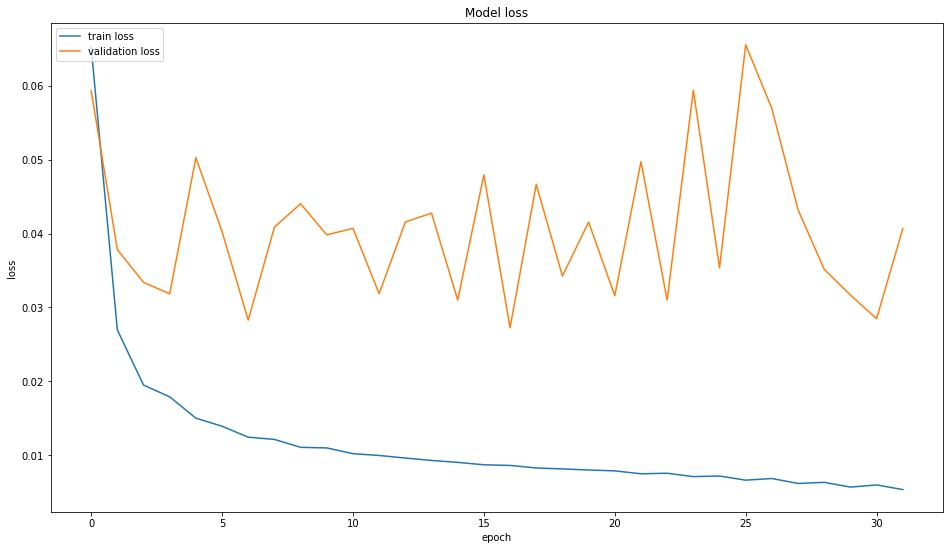

In [8]:
tf.keras.backend.clear_session()
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')

project_dir = "/Users/trungnguyen/Desktop/cttn-khmt-k64/deep learning/project/DL_HUST_Project"
folder_save = project_dir + f'/Results/GRU/history_{hist_window}_future_{horizon}_version_{version}'
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(GRU_model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                           min_delta=0, patience=15, 
                                                                           verbose=1, mode='min'),
                                          tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss',
                                                                             save_best_only=True, 
                                                                             mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans[0])

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)